In [14]:
import torch
import random
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

In [2]:
def preprocessing(data, flag=True):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    if flag:
        scaler = MinMaxScaler()
        data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    return data

In [3]:
columns = ['Open', 'Low', 'High', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower']
data = pd.read_csv('/kaggle/input/meta-dataset/META_day.csv')
data = preprocessing(data)

/tmp/ipykernel_31/489962627.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/tmp/ipykernel_31/489962627.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [4]:
def create_sequences(data, targets, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  
        label = targets[i + sequence_length] 
        sequences.append(seq)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    sequences = np.transpose(sequences, (0, 2, 1))  
    return sequences, labels

In [5]:
def prepare_dataloaders(data, feature_columns, target_column, sequence_length, batch_size, test_size=0.1):
    X = data[feature_columns].values
    y = data[target_column].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=test_size, shuffle=False)
    
    x_train, y_train = create_sequences(X_train, Y_train, sequence_length)
    x_val, y_val = create_sequences(X_val, Y_val, sequence_length)
    x_test, y_test = create_sequences(X_test, Y_test, sequence_length)
    
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader, y_test

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, drop_prob, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.dropout = nn.Dropout(drop_prob)
        self.batchnorm = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.dropout(out)
        out = self.batchnorm(out)
        out = F.relu(out)
        return out


class FractalBlock(nn.Module):
    def __init__(self, n_columns, input_channels, output_channels, kernel_size, local_drop_prob, dropout_prob,
                 global_drop_prob, training=True):
        super().__init__()
        self.n_columns = n_columns
        self.columns = nn.ModuleList([nn.ModuleList() for _ in range(n_columns)])
        self.max_depth = 2 ** (n_columns - 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.local_drop_prob = local_drop_prob
        self.global_drop_prob = global_drop_prob
        self.count = np.zeros([self.max_depth], dtype=int)
        
        dist = self.max_depth
        for col in self.columns:
            for i in range(self.max_depth):
                if (i + 1) % dist == 0:
                    first_block = (i + 1 == dist)
                    if first_block:
                        cur_input = input_channels
                    else:
                        cur_input = output_channels

                    module = ConvBlock(cur_input, output_channels, kernel_size, dropout_prob)
                    self.count[i] += 1
                else:
                    module = None
                col.append(module)
            dist //= 2

    def drop_mask(self, B, global_cols, n_cols):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if isinstance(global_cols, np.ndarray):
            global_cols = torch.tensor(global_cols, device=device)
        
        GB = global_cols.shape[0]
        gdrop_cols = global_cols - (self.n_columns - n_cols)
        gdrop_indices = torch.where(gdrop_cols >= 0)[0]
        
        gdrop_mask = torch.zeros(n_cols, GB, device=device, dtype=torch.float32)
        if gdrop_indices.shape[0] > 0:
            gdrop_mask[gdrop_cols[gdrop_indices], gdrop_indices] = 1.0
        
        LB = B - GB
        prob_tensor = torch.ones(n_cols, LB, device=device) * (1. - self.local_drop_prob)
        ldrop_mask = torch.bernoulli(prob_tensor)
        alive_count = ldrop_mask.sum(dim=0)
        
        dead_indices = torch.where(alive_count == 0.)[0]
        if dead_indices.shape[0] > 0:
            random_rows = torch.randint(0, n_cols, (dead_indices.shape[0],), device=device)
            ldrop_mask[random_rows, dead_indices] = 1.0
        drop_mask = torch.cat((gdrop_mask, ldrop_mask), dim=1)
        return drop_mask

    def join(self, outs, global_cols):
        n_cols = len(outs)
        out = torch.stack(outs) 

        if self.training:
            mask = self.drop_mask(out.size(1), global_cols, n_cols).to(out.device)  # [n_cols, B]
            mask = mask.view(*mask.size(), 1, 1) 
            n_alive = mask.sum(dim=0)  
            masked_out = out * mask  
            n_alive[n_alive == 0.] = 1.
            out = masked_out.sum(dim=0) / n_alive  
        else:
            out = out.mean(dim=0)
        return out

    def forward(self, x, global_cols):
        outs = [x] * self.n_columns
        for i in range(self.max_depth):
            st = self.n_columns - self.count[i]
            cur_outs = []

            for c in range(st, self.n_columns):
                cur_in = outs[c]
                cur_module = self.columns[c][i]
                if cur_module is not None:
                    cur_outs.append(cur_module(cur_in))

            joined = self.join(cur_outs, global_cols)

            for c in range(st, self.n_columns):
                outs[c] = joined

        outs[-1] = self.dropout(outs[-1])
        return outs[-1]


class FractalNet(nn.Module):
    def __init__(self, n_blocks, n_columns, input_channels, out_channels, kernel_size, local_drop_prob, drop_prob,
                 global_drop_prob):
        super().__init__()
        self.n_blocks = n_blocks
        self.n_columns = n_columns
        self.input_channels = input_channels
        self.out_channels = out_channels
        self.local_drop_prob = local_drop_prob
        self.global_drop_prob = global_drop_prob

        self.layers = nn.ModuleList()
        total_layers = 0

        current_channels = input_channels
        for i in range(self.n_blocks):
            print(f"Block {i + 1}, Input channels: {current_channels}, Output channels: {out_channels[i]}")
            fractal_block = FractalBlock(n_columns, current_channels, out_channels[i], kernel_size, local_drop_prob,
                                         drop_prob,
                                         global_drop_prob)
            self.layers.append(fractal_block)
            self.layers.append(nn.BatchNorm1d(out_channels[i]))
            if i < self.n_blocks - 1:
                self.layers.append(nn.AvgPool1d(2))
            else:
                self.layers.append(nn.AdaptiveAvgPool1d(1))
            total_layers += fractal_block.max_depth
            current_channels = out_channels[i]
    
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(out_channels[-1], 1))
        self.initialize_weights()

        print(f"Total layers in network: {total_layers}")

    def initialize_weights(self):
        for name, param in self.named_parameters():
            if param.dim() > 1:  
                nn.init.xavier_uniform_(param)
            else: 
                if 'bn.weight' in name:
                    nn.init.ones_(param)
                elif 'bn.bias' in name or 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        GB = int(x.size(0) * self.global_drop_prob)
        global_cols = None
        out = x

        for layer in self.layers:
            if isinstance(layer, FractalBlock):
                global_cols = np.random.randint(0, self.n_columns, size=[GB])
                out = layer(out, global_cols)
            else:
                out = layer(out)
        return out

In [7]:
def evaluate_model(model, dataloader, criterion, device='cuda'):
    model.eval()
    total_loss = 0.0
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            all_targets.append(targets.cpu().detach().numpy())
            all_outputs.append(outputs.cpu().detach().numpy())
            
    avg_loss = total_loss / len(dataloader.dataset)
    targets = np.concatenate(all_targets)
    outputs = np.concatenate(all_outputs)
    
    mse = np.mean((outputs - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(outputs - targets))
    
    return avg_loss, rmse, mae

In [8]:
def plot_metrics(predictions, targets, name):
    
    predictions_natural = predictions.flatten()
    targets_natural = targets.flatten() 

    plt.figure(figsize=(10, 6))
    plt.plot(targets_natural, label="Real Values", color='blue')
    plt.plot(predictions_natural, label="Predicted Values", color='red', linestyle='dashed')
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Real vs Predicted Values')
    plt.legend()
    plt.savefig(name, dpi=99, bbox_inches='tight')
    plt.show()

In [28]:
def evaluate_on_test(model, test_dataloader, criterion, device):
    model.eval()  
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():  
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            loss = criterion(outputs, targets)  
            test_loss += loss.item() * inputs.size(0) 
            
            pred_np = outputs.cpu().numpy()
            target_np = targets.cpu().numpy()
            
            if np.ndim(pred_np) == 0:
                pred_np = np.array([pred_np])
            if np.ndim(target_np) == 0:
                target_np = np.array([target_np])
            
            all_predictions.append(outputs.cpu().numpy())  
            all_targets.append(targets.cpu().numpy())
    
    test_loss /= len(test_dataloader.dataset)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mae = mean_absolute_error(all_targets, all_predictions)
    
    return all_predictions, all_targets

In [10]:
def train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, name_model=""):
    model.to(device)
    best_val_loss = float('inf')
    
    train_rmse_list, train_mae_list = [], []
    val_rmse_list, val_mae_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(num_epochs):
        model.train()
        all_train_targets = []
        all_train_outputs = []
        batch_inputs, batch_targets = [], []

        for inputs, targets in train_dataloader:
            batch_inputs.append(inputs.to(device))
            batch_targets.append(targets.float().to(device))
        
        inputs = torch.cat(batch_inputs)
        targets = torch.cat(batch_targets)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        outputs = outputs.view_as(targets)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss = loss.item() * inputs.size(0)
        all_train_targets.append(targets.cpu().detach().numpy())
        all_train_outputs.append(outputs.cpu().detach().numpy())

        train_targets = np.concatenate(all_train_targets)
        train_outputs = np.concatenate(all_train_outputs)

        train_mse = np.mean((train_outputs - train_targets) ** 2)
        train_rmse = np.sqrt(train_mse)
        train_mae = np.mean(np.abs(train_outputs - train_targets))

        train_rmse_list.append(train_rmse)
        train_mae_list.append(train_mae)
        train_loss_list.append(train_loss / len(train_dataloader.dataset))

        val_loss, val_rmse, val_mae = evaluate_model(model, val_dataloader, criterion, device)
        val_rmse_list.append(val_rmse)
        val_mae_list.append(val_mae)
        val_loss_list.append(val_loss)

        if val_loss < best_val_loss and name_model != '':
            best_val_loss = val_loss
            torch.save(model.state_dict(), name_model)

        if ((epoch + 1) % 100) == 0:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
            print(f'Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')

    if name_model != '':
        torch.save(model.state_dict(), name_model)

    return train_loss_list, val_loss_list

In [11]:
def evaluate_and_plot(test_dataloader, model, criterion, device, png, train_loss_list, val_loss_list, num_epochs):
    model.to(device)

    test_loss, test_rmse, test_mae = evaluate_model(model, test_dataloader, criterion, device)
    predictions, targets = evaluate_on_test(model, test_dataloader, criterion, device)

    print('\nFinal Results:')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')

    plot_metrics(predictions, targets, png)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [12]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 

# META

In [15]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.2460, Train MAE: 0.1043
Val RMSE: 0.0309, Val MAE: 0.0255
Epoch 200/400:
Train RMSE: 0.1968, Train MAE: 0.0720
Val RMSE: 0.0292, Val MAE: 0.0235
Epoch 300/400:
Train RMSE: 0.2072, Train MAE: 0.1134
Val RMSE: 0.0214, Val MAE: 0.0167
Epoch 400/400:
Train RMSE: 0.1339, Train MAE: 0.0433
Val RMSE: 0.0259, Val MAE: 0.0209


## LERNING RATE

In [16]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.3680, Train MAE: 0.2036
Val RMSE: 0.1205, Val MAE: 0.1157
Epoch 200/400:
Train RMSE: 0.3321, Train MAE: 0.1629
Val RMSE: 0.0748, Val MAE: 0.0697
Epoch 300/400:
Train RMSE: 0.2694, Train MAE: 0.1396
Val RMSE: 0.0534, Val MAE: 0.0486
Epoch 400/400:
Train RMSE: 0.2548, Train MAE: 0.1246
Val RMSE: 0.0364, Val MAE: 0.0316


In [17]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.5123, Train MAE: 0.3232
Val RMSE: 0.2991, Val MAE: 0.2783
Epoch 200/400:
Train RMSE: 0.5093, Train MAE: 0.3092
Val RMSE: 0.2665, Val MAE: 0.2506
Epoch 300/400:
Train RMSE: 0.4530, Train MAE: 0.2867
Val RMSE: 0.2420, Val MAE: 0.2296
Epoch 400/400:
Train RMSE: 0.4375, Train MAE: 0.2685
Val RMSE: 0.2208, Val MAE: 0.2107


## NUM BLOCK

In [18]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (16, 32, 64)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 16
Block 2, Input channels: 16, Output channels: 32
Block 3, Input channels: 32, Output channels: 64
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.6114, Train MAE: 0.3008
Val RMSE: 0.2372, Val MAE: 0.2154
Epoch 200/400:
Train RMSE: 0.5161, Train MAE: 0.2496
Val RMSE: 0.1876, Val MAE: 0.1647
Epoch 300/400:
Train RMSE: 0.4962, Train MAE: 0.2242
Val RMSE: 0.1552, Val MAE: 0.1362
Epoch 400/400:
Train RMSE: 0.5106, Train MAE: 0.2128
Val RMSE: 0.1416, Val MAE: 0.1242


## NUM FILTRERS

In [19]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (32, 64)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.2422, Train MAE: 0.1056
Val RMSE: 0.0597, Val MAE: 0.0541
Epoch 200/400:
Train RMSE: 0.2664, Train MAE: 0.0848
Val RMSE: 0.0404, Val MAE: 0.0349
Epoch 300/400:
Train RMSE: 0.1815, Train MAE: 0.0648
Val RMSE: 0.0349, Val MAE: 0.0282
Epoch 400/400:
Train RMSE: 0.1392, Train MAE: 0.0553
Val RMSE: 0.0295, Val MAE: 0.0250


## NUM COLUMNS

In [20]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.2203, Train MAE: 0.1218
Val RMSE: 0.0409, Val MAE: 0.0325
Epoch 200/400:
Train RMSE: 0.1523, Train MAE: 0.0796
Val RMSE: 0.0247, Val MAE: 0.0200
Epoch 300/400:
Train RMSE: 0.1403, Train MAE: 0.0633
Val RMSE: 0.0224, Val MAE: 0.0183
Epoch 400/400:
Train RMSE: 0.1065, Train MAE: 0.0463
Val RMSE: 0.0234, Val MAE: 0.0196


## NUM EPOCHES

In [21]:
seed_everything(0)
num_epochs = 800
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/800:
Train RMSE: 0.2460, Train MAE: 0.1043
Val RMSE: 0.0309, Val MAE: 0.0255
Epoch 200/800:
Train RMSE: 0.1968, Train MAE: 0.0720
Val RMSE: 0.0292, Val MAE: 0.0235
Epoch 300/800:
Train RMSE: 0.2072, Train MAE: 0.1134
Val RMSE: 0.0214, Val MAE: 0.0167
Epoch 400/800:
Train RMSE: 0.1339, Train MAE: 0.0433
Val RMSE: 0.0259, Val MAE: 0.0209
Epoch 500/800:
Train RMSE: 0.0951, Train MAE: 0.0391
Val RMSE: 0.0222, Val MAE: 0.0180
Epoch 600/800:
Train RMSE: 0.0893, Train MAE: 0.0332
Val RMSE: 0.0272, Val MAE: 0.0235
Epoch 700/800:
Train RMSE: 0.1443, Train MAE: 0.0319
Val RMSE: 0.0322, Val MAE: 0.0289
Epoch 800/800:
Train RMSE: 0.1090, Train MAE: 0.0315
Val RMSE: 0.0282, Val MAE: 0.0238


## GD

In [22]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.2373, Train MAE: 0.1054
Val RMSE: 0.0352, Val MAE: 0.0305
Epoch 200/400:
Train RMSE: 0.2141, Train MAE: 0.0778
Val RMSE: 0.0239, Val MAE: 0.0188
Epoch 300/400:
Train RMSE: 0.2373, Train MAE: 0.0685
Val RMSE: 0.0211, Val MAE: 0.0161
Epoch 400/400:
Train RMSE: 0.1945, Train MAE: 0.0579
Val RMSE: 0.0248, Val MAE: 0.0207


In [23]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.4

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.2440, Train MAE: 0.1254
Val RMSE: 0.0731, Val MAE: 0.0660
Epoch 200/400:
Train RMSE: 0.2082, Train MAE: 0.0849
Val RMSE: 0.0332, Val MAE: 0.0282
Epoch 300/400:
Train RMSE: 0.1649, Train MAE: 0.0653
Val RMSE: 0.0260, Val MAE: 0.0213
Epoch 400/400:
Train RMSE: 0.1371, Train MAE: 0.0497
Val RMSE: 0.0274, Val MAE: 0.0237


In [24]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.1

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.2718, Train MAE: 0.1049
Val RMSE: 0.0535, Val MAE: 0.0488
Epoch 200/400:
Train RMSE: 0.2956, Train MAE: 0.0761
Val RMSE: 0.0157, Val MAE: 0.0123
Epoch 300/400:
Train RMSE: 0.1665, Train MAE: 0.0793
Val RMSE: 0.0486, Val MAE: 0.0441
Epoch 400/400:
Train RMSE: 0.2111, Train MAE: 0.0472
Val RMSE: 0.0284, Val MAE: 0.0241


## LD

In [25]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.2497, Train MAE: 0.0932
Val RMSE: 0.0345, Val MAE: 0.0281
Epoch 200/400:
Train RMSE: 0.2487, Train MAE: 0.0711
Val RMSE: 0.0440, Val MAE: 0.0366
Epoch 300/400:
Train RMSE: 0.1545, Train MAE: 0.0784
Val RMSE: 0.0282, Val MAE: 0.0229
Epoch 400/400:
Train RMSE: 0.0962, Train MAE: 0.0462
Val RMSE: 0.0192, Val MAE: 0.0144


In [26]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.4
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.2172, Train MAE: 0.1061
Val RMSE: 0.0403, Val MAE: 0.0356
Epoch 200/400:
Train RMSE: 0.2025, Train MAE: 0.0761
Val RMSE: 0.0291, Val MAE: 0.0234
Epoch 300/400:
Train RMSE: 0.2250, Train MAE: 0.1145
Val RMSE: 0.0324, Val MAE: 0.0278
Epoch 400/400:
Train RMSE: 0.1217, Train MAE: 0.0464
Val RMSE: 0.0263, Val MAE: 0.0216


## TIME STEP = 5

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.2720, Train MAE: 0.1463
Val RMSE: 0.0399, Val MAE: 0.0318
Epoch 200/400:
Train RMSE: 0.1685, Train MAE: 0.0914
Val RMSE: 0.0369, Val MAE: 0.0300
Epoch 300/400:
Train RMSE: 0.1107, Train MAE: 0.0601
Val RMSE: 0.0371, Val MAE: 0.0325
Epoch 400/400:
Train RMSE: 0.0728, Train MAE: 0.0420
Val RMSE: 0.0342, Val MAE: 0.0301

Final Results:
Test RMSE: 0.0654
Test MAE: 0.0588


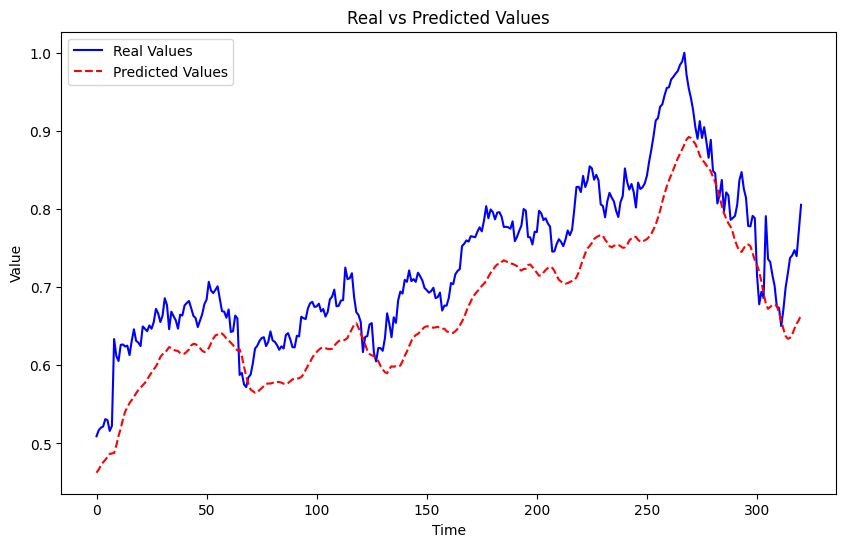

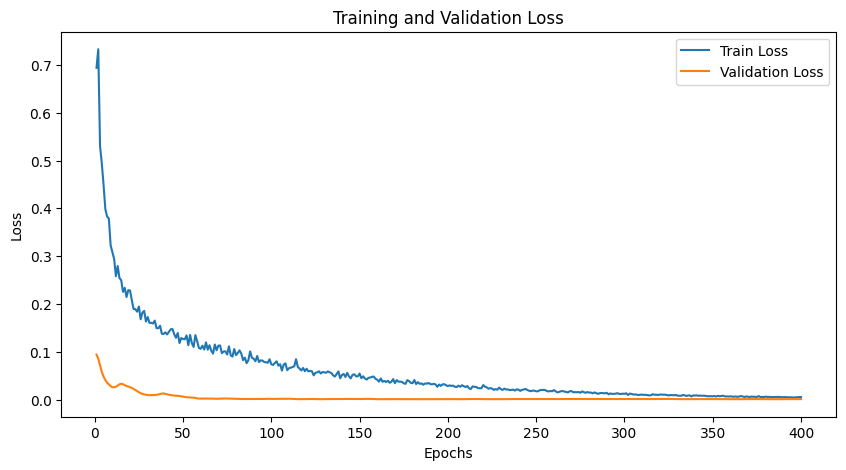

In [57]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_meta_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_5_fractal.png', train_losses, val_losses, num_epochs)

## TIME STEP = 10

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.2203, Train MAE: 0.1218
Val RMSE: 0.0409, Val MAE: 0.0325
Epoch 200/400:
Train RMSE: 0.1523, Train MAE: 0.0796
Val RMSE: 0.0247, Val MAE: 0.0200
Epoch 300/400:
Train RMSE: 0.1403, Train MAE: 0.0633
Val RMSE: 0.0224, Val MAE: 0.0183
Epoch 400/400:
Train RMSE: 0.1065, Train MAE: 0.0463
Val RMSE: 0.0234, Val MAE: 0.0196

Final Results:
Test RMSE: 0.0423
Test MAE: 0.0341


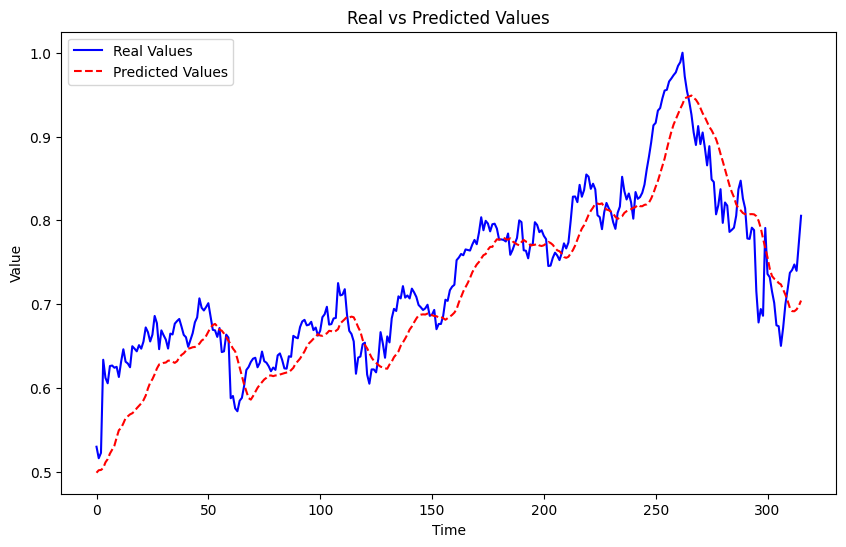

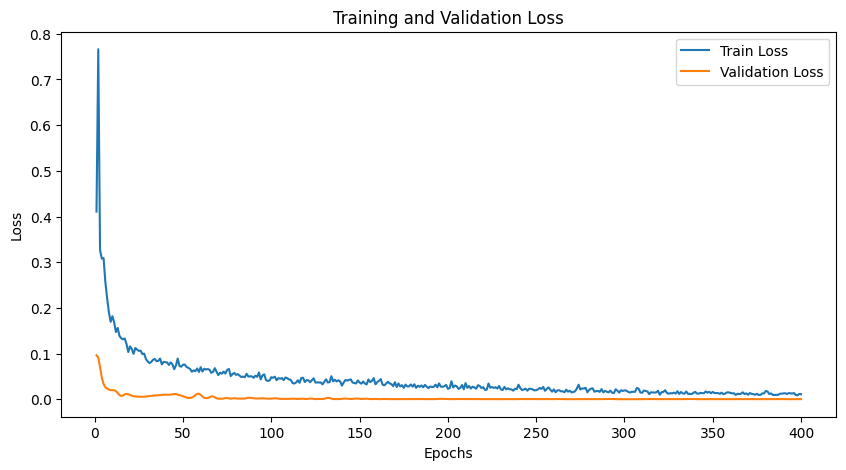

In [58]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_meta_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_10_fractal.png', train_losses, val_losses, num_epochs)

## TIME STEP = 20

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.1860, Train MAE: 0.1077
Val RMSE: 0.0578, Val MAE: 0.0488
Epoch 200/400:
Train RMSE: 0.1439, Train MAE: 0.0752
Val RMSE: 0.0291, Val MAE: 0.0238
Epoch 300/400:
Train RMSE: 0.1322, Train MAE: 0.0603
Val RMSE: 0.0283, Val MAE: 0.0227
Epoch 400/400:
Train RMSE: 0.1040, Train MAE: 0.0471
Val RMSE: 0.0202, Val MAE: 0.0163

Final Results:
Test RMSE: 0.0636
Test MAE: 0.0540


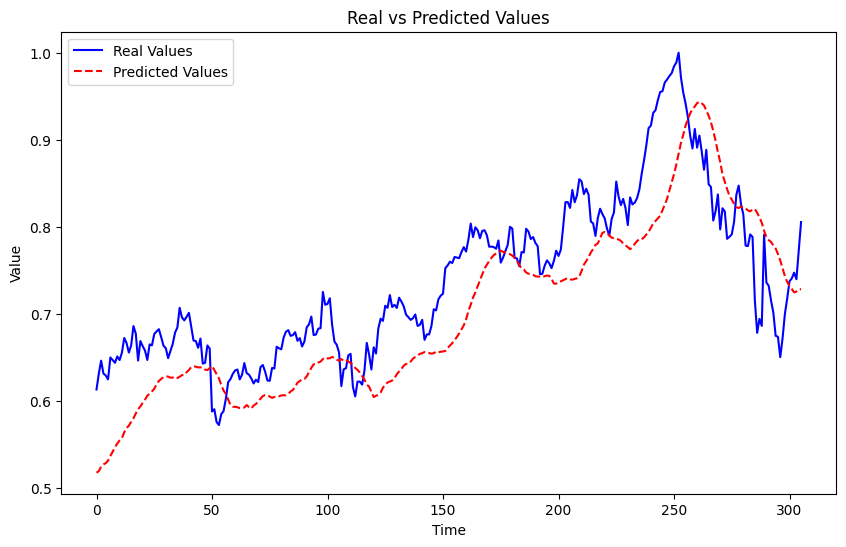

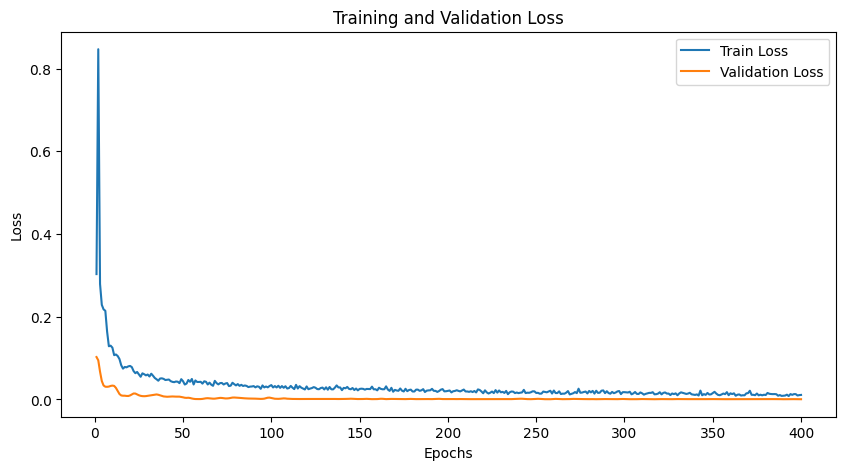

In [31]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_meta_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_20_fractal.png', train_losses, val_losses, num_epochs)

## Without indicators

In [33]:
cols = ['Open', 'Low', 'High', 'Volume', 'Close']
cols1 = ['Open', 'Low', 'High', 'Volume']

data_without_indicators = data[cols]

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.3518, Train MAE: 0.1668
Val RMSE: 0.0570, Val MAE: 0.0521
Epoch 200/400:
Train RMSE: 0.2410, Train MAE: 0.0996
Val RMSE: 0.0398, Val MAE: 0.0346
Epoch 300/400:
Train RMSE: 0.1855, Train MAE: 0.0727
Val RMSE: 0.0336, Val MAE: 0.0300
Epoch 400/400:
Train RMSE: 0.1552, Train MAE: 0.0565
Val RMSE: 0.0346, Val MAE: 0.0310

Final Results:
Test RMSE: 0.0575
Test MAE: 0.0514


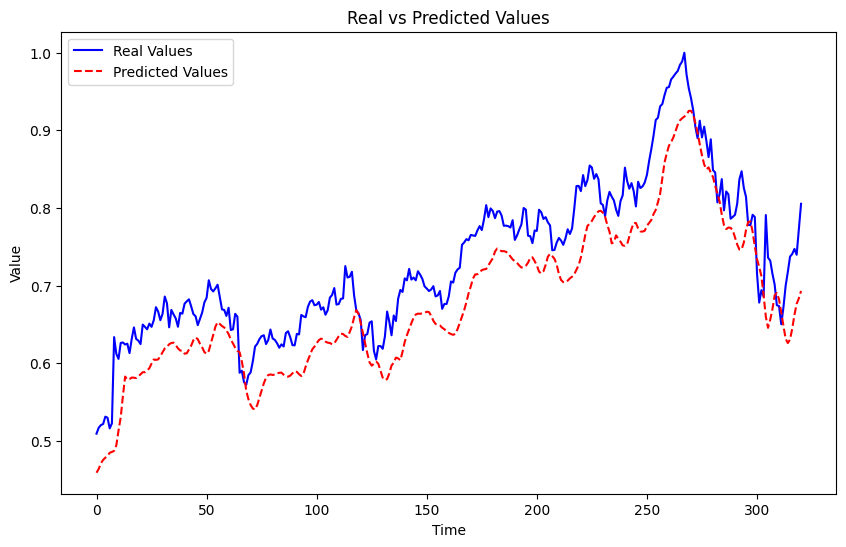

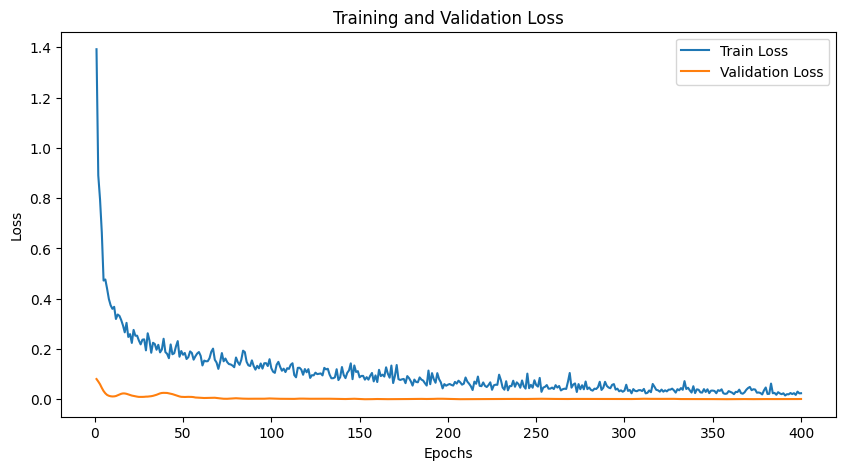

In [34]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 4
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data_without_indicators, cols1, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_meta_without_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device,  'meta_step_5_without_fractal.png', train_losses, val_losses, num_epochs)

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.2662, Train MAE: 0.1365
Val RMSE: 0.0930, Val MAE: 0.0899
Epoch 200/400:
Train RMSE: 0.2075, Train MAE: 0.0954
Val RMSE: 0.0476, Val MAE: 0.0444
Epoch 300/400:
Train RMSE: 0.1774, Train MAE: 0.0794
Val RMSE: 0.0395, Val MAE: 0.0368
Epoch 400/400:
Train RMSE: 0.1538, Train MAE: 0.0640
Val RMSE: 0.0334, Val MAE: 0.0303

Final Results:
Test RMSE: 0.0672
Test MAE: 0.0604


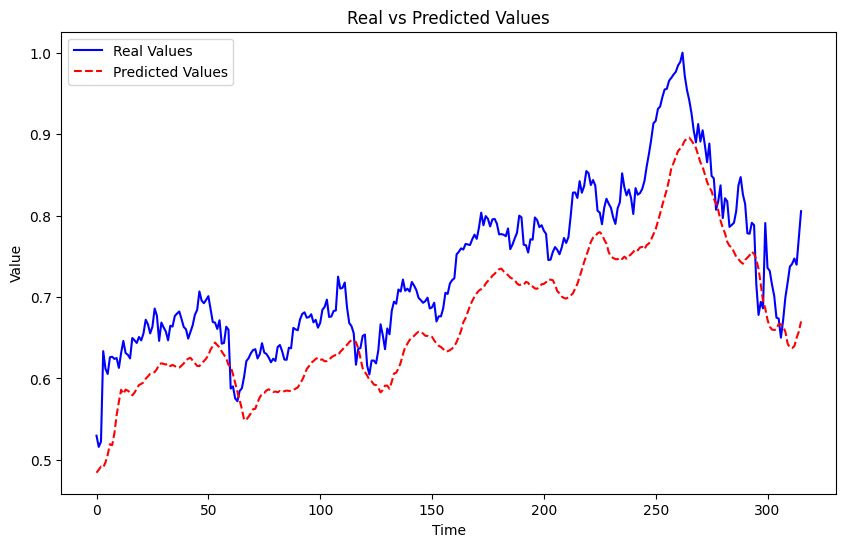

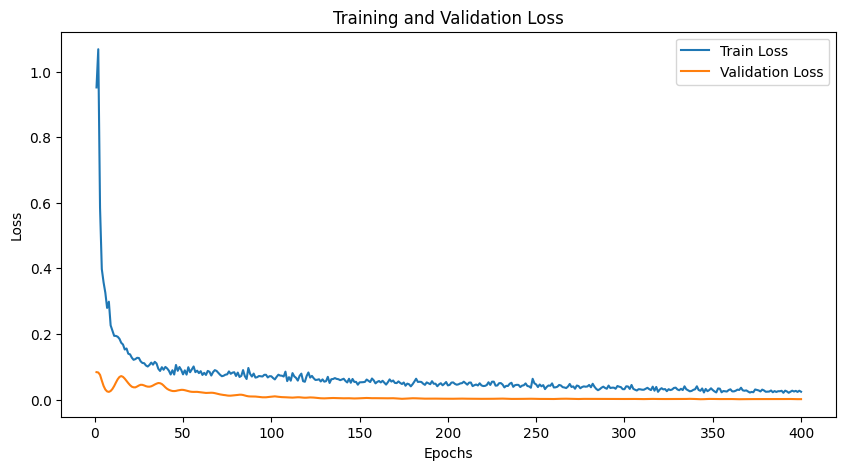

In [35]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 4
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data_without_indicators, cols1, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_meta_without_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_10_without_fractal.png', train_losses, val_losses, num_epochs)

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.1994, Train MAE: 0.1012
Val RMSE: 0.0589, Val MAE: 0.0550
Epoch 200/400:
Train RMSE: 0.1703, Train MAE: 0.0805
Val RMSE: 0.0363, Val MAE: 0.0319
Epoch 300/400:
Train RMSE: 0.1534, Train MAE: 0.0636
Val RMSE: 0.0241, Val MAE: 0.0196
Epoch 400/400:
Train RMSE: 0.1178, Train MAE: 0.0496
Val RMSE: 0.0267, Val MAE: 0.0226

Final Results:
Test RMSE: 0.0653
Test MAE: 0.0517


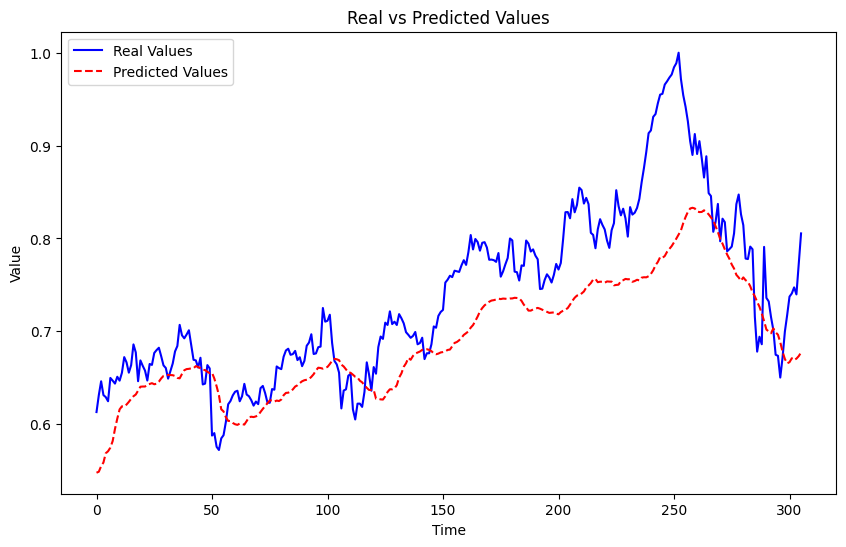

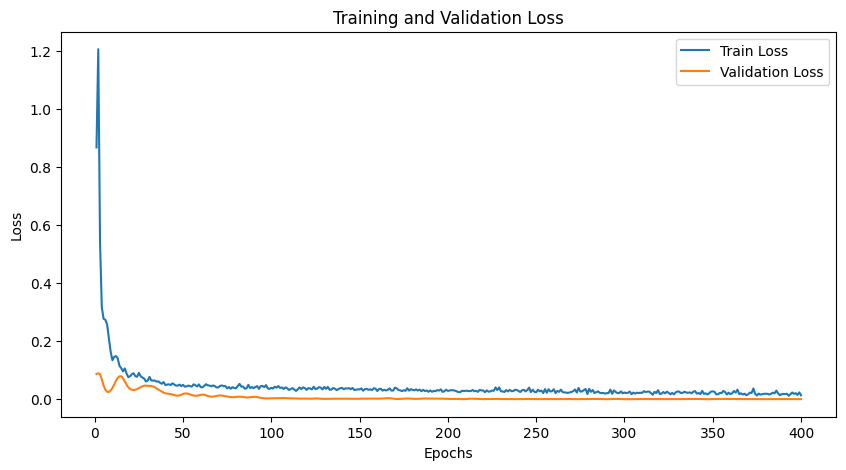

In [36]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 4
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data_without_indicators, cols1, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_meta_without_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_20_without_fractal.png', train_losses, val_losses, num_epochs)

# TESLA

In [37]:
columns = ['Open', 'Low', 'High', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower']
tesla_df = pd.read_csv('/kaggle/input/tesla-dataset/Tesla_day.csv')
tesla_df = preprocessing(tesla_df)

/tmp/ipykernel_31/489962627.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/tmp/ipykernel_31/489962627.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [38]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.4480, Train MAE: 0.1130
Val RMSE: 0.1576, Val MAE: 0.1441
Epoch 200/400:
Train RMSE: 0.2038, Train MAE: 0.0826
Val RMSE: 0.1336, Val MAE: 0.1162
Epoch 300/400:
Train RMSE: 0.2045, Train MAE: 0.0625
Val RMSE: 0.1108, Val MAE: 0.0912
Epoch 400/400:
Train RMSE: 0.3022, Train MAE: 0.0551
Val RMSE: 0.0797, Val MAE: 0.0587


## LR

In [51]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.3493, Train MAE: 0.1930
Val RMSE: 0.4169, Val MAE: 0.4072
Epoch 200/400:
Train RMSE: 0.3254, Train MAE: 0.1723
Val RMSE: 0.3747, Val MAE: 0.3671
Epoch 300/400:
Train RMSE: 0.3179, Train MAE: 0.1540
Val RMSE: 0.3438, Val MAE: 0.3377
Epoch 400/400:
Train RMSE: 0.2852, Train MAE: 0.1431
Val RMSE: 0.3160, Val MAE: 0.3101


In [50]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.5133, Train MAE: 0.2941
Val RMSE: 0.4736, Val MAE: 0.4632
Epoch 200/400:
Train RMSE: 0.4852, Train MAE: 0.2696
Val RMSE: 0.4698, Val MAE: 0.4595
Epoch 300/400:
Train RMSE: 0.4314, Train MAE: 0.2415
Val RMSE: 0.4628, Val MAE: 0.4529
Epoch 400/400:
Train RMSE: 0.4099, Train MAE: 0.2325
Val RMSE: 0.4624, Val MAE: 0.4526


## NUM FRACTAL BLOCK

In [49]:
seed_everything(0)
num_epochs = 400
n_blocks = 4
n_columns = 4
in_channels = 11
out_channels = (16, 32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 16
Block 2, Input channels: 16, Output channels: 32
Block 3, Input channels: 32, Output channels: 64
Block 4, Input channels: 64, Output channels: 128
Total layers in network: 32
Epoch 100/400:
Train RMSE: 0.4817, Train MAE: 0.1898
Val RMSE: 0.3900, Val MAE: 0.3766
Epoch 200/400:
Train RMSE: 0.3174, Train MAE: 0.1406
Val RMSE: 0.4154, Val MAE: 0.4043
Epoch 300/400:
Train RMSE: 0.2832, Train MAE: 0.1056
Val RMSE: 0.3746, Val MAE: 0.3648
Epoch 400/400:
Train RMSE: 0.2582, Train MAE: 0.0864
Val RMSE: 0.2987, Val MAE: 0.2865


In [48]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.1986, Train MAE: 0.0943
Val RMSE: 0.1117, Val MAE: 0.0928
Epoch 200/400:
Train RMSE: 0.2302, Train MAE: 0.0619
Val RMSE: 0.1235, Val MAE: 0.1120
Epoch 300/400:
Train RMSE: 0.1202, Train MAE: 0.0435
Val RMSE: 0.0610, Val MAE: 0.0510
Epoch 400/400:
Train RMSE: 0.1054, Train MAE: 0.0410
Val RMSE: 0.0511, Val MAE: 0.0416


## NUM COLS

In [47]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 3
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 12
Epoch 100/400:
Train RMSE: 0.2589, Train MAE: 0.1130
Val RMSE: 0.1274, Val MAE: 0.1057
Epoch 200/400:
Train RMSE: 0.1896, Train MAE: 0.0796
Val RMSE: 0.0867, Val MAE: 0.0638
Epoch 300/400:
Train RMSE: 0.1663, Train MAE: 0.0643
Val RMSE: 0.0804, Val MAE: 0.0590
Epoch 400/400:
Train RMSE: 0.1348, Train MAE: 0.0532
Val RMSE: 0.0767, Val MAE: 0.0606


## NUMBER EPOCHES

In [46]:
seed_everything(0)
num_epochs = 800
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/800:
Train RMSE: 0.4480, Train MAE: 0.1130
Val RMSE: 0.1576, Val MAE: 0.1441
Epoch 200/800:
Train RMSE: 0.2038, Train MAE: 0.0826
Val RMSE: 0.1336, Val MAE: 0.1162
Epoch 300/800:
Train RMSE: 0.2045, Train MAE: 0.0625
Val RMSE: 0.1108, Val MAE: 0.0912
Epoch 400/800:
Train RMSE: 0.3022, Train MAE: 0.0551
Val RMSE: 0.0797, Val MAE: 0.0587
Epoch 500/800:
Train RMSE: 0.2085, Train MAE: 0.0639
Val RMSE: 0.1332, Val MAE: 0.1191
Epoch 600/800:
Train RMSE: 0.1901, Train MAE: 0.0472
Val RMSE: 0.0698, Val MAE: 0.0507
Epoch 700/800:
Train RMSE: 0.1316, Train MAE: 0.0389
Val RMSE: 0.0742, Val MAE: 0.0559
Epoch 800/800:
Train RMSE: 0.0996, Train MAE: 0.0345
Val RMSE: 0.0724, Val MAE: 0.0599


## NUMBER FILTERS

In [45]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (16, 32, 64)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 16
Block 2, Input channels: 16, Output channels: 32
Block 3, Input channels: 32, Output channels: 64
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.2615, Train MAE: 0.1371
Val RMSE: 0.2835, Val MAE: 0.2759
Epoch 200/400:
Train RMSE: 0.2587, Train MAE: 0.1076
Val RMSE: 0.1360, Val MAE: 0.1096
Epoch 300/400:
Train RMSE: 0.1816, Train MAE: 0.0715
Val RMSE: 0.0972, Val MAE: 0.0739
Epoch 400/400:
Train RMSE: 0.1640, Train MAE: 0.0620
Val RMSE: 0.0829, Val MAE: 0.0629


## GLOBAL DROPOUT 

In [44]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.4

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.3141, Train MAE: 0.1237
Val RMSE: 0.2051, Val MAE: 0.1911
Epoch 200/400:
Train RMSE: 0.2531, Train MAE: 0.0989
Val RMSE: 0.0966, Val MAE: 0.0747
Epoch 300/400:
Train RMSE: 0.2890, Train MAE: 0.0744
Val RMSE: 0.0819, Val MAE: 0.0672
Epoch 400/400:
Train RMSE: 0.2879, Train MAE: 0.0610
Val RMSE: 0.0841, Val MAE: 0.0703


In [43]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.2939, Train MAE: 0.1179
Val RMSE: 0.1956, Val MAE: 0.1827
Epoch 200/400:
Train RMSE: 0.5314, Train MAE: 0.0904
Val RMSE: 0.1161, Val MAE: 0.1003
Epoch 300/400:
Train RMSE: 0.1760, Train MAE: 0.0591
Val RMSE: 0.0729, Val MAE: 0.0563
Epoch 400/400:
Train RMSE: 0.2178, Train MAE: 0.0527
Val RMSE: 0.0709, Val MAE: 0.0513


In [42]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.1

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.2827, Train MAE: 0.1133
Val RMSE: 0.1862, Val MAE: 0.1755
Epoch 200/400:
Train RMSE: 0.2210, Train MAE: 0.0812
Val RMSE: 0.1151, Val MAE: 0.0910
Epoch 300/400:
Train RMSE: 0.2589, Train MAE: 0.0750
Val RMSE: 0.0899, Val MAE: 0.0696
Epoch 400/400:
Train RMSE: 0.1406, Train MAE: 0.0528
Val RMSE: 0.0888, Val MAE: 0.0662


## LOCAL DROPOUT

In [41]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.4
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.4374, Train MAE: 0.1317
Val RMSE: 0.2717, Val MAE: 0.2639
Epoch 200/400:
Train RMSE: 0.3349, Train MAE: 0.0852
Val RMSE: 0.1502, Val MAE: 0.1208
Epoch 300/400:
Train RMSE: 0.2596, Train MAE: 0.0649
Val RMSE: 0.1250, Val MAE: 0.1033
Epoch 400/400:
Train RMSE: 0.1161, Train MAE: 0.0448
Val RMSE: 0.1097, Val MAE: 0.0791


In [40]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.3119, Train MAE: 0.1127
Val RMSE: 0.0917, Val MAE: 0.0726
Epoch 200/400:
Train RMSE: 0.1870, Train MAE: 0.0743
Val RMSE: 0.0527, Val MAE: 0.0416
Epoch 300/400:
Train RMSE: 0.1854, Train MAE: 0.0572
Val RMSE: 0.0486, Val MAE: 0.0392
Epoch 400/400:
Train RMSE: 0.1892, Train MAE: 0.0453
Val RMSE: 0.0707, Val MAE: 0.0587


In [39]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.1
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.2627, Train MAE: 0.1023
Val RMSE: 0.0912, Val MAE: 0.0730
Epoch 200/400:
Train RMSE: 0.2434, Train MAE: 0.0736
Val RMSE: 0.0549, Val MAE: 0.0449
Epoch 300/400:
Train RMSE: 0.1876, Train MAE: 0.0535
Val RMSE: 0.0563, Val MAE: 0.0455
Epoch 400/400:
Train RMSE: 0.1443, Train MAE: 0.0448
Val RMSE: 0.0568, Val MAE: 0.0453


## STEP = 5

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.3083, Train MAE: 0.1623
Val RMSE: 0.0635, Val MAE: 0.0519
Epoch 200/400:
Train RMSE: 0.2621, Train MAE: 0.1203
Val RMSE: 0.0895, Val MAE: 0.0747
Epoch 300/400:
Train RMSE: 0.1996, Train MAE: 0.0878
Val RMSE: 0.0506, Val MAE: 0.0404
Epoch 400/400:
Train RMSE: 0.1520, Train MAE: 0.0658
Val RMSE: 0.0430, Val MAE: 0.0323

Final Results:
Test RMSE: 0.0456
Test MAE: 0.0323


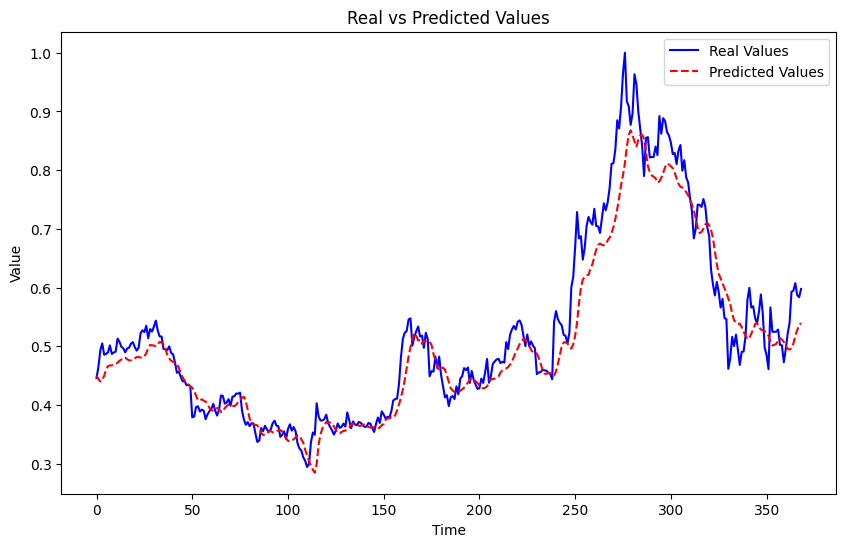

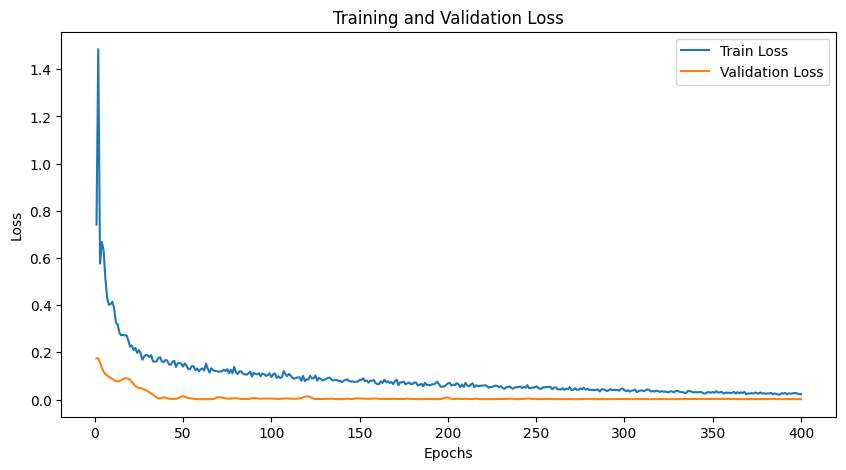

In [60]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.1
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_tesla_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_5_fractal.png', train_losses, val_losses, num_epochs)

## STEP = 10

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.2541, Train MAE: 0.1062
Val RMSE: 0.0805, Val MAE: 0.0723
Epoch 200/400:
Train RMSE: 0.2336, Train MAE: 0.0781
Val RMSE: 0.0527, Val MAE: 0.0450
Epoch 300/400:
Train RMSE: 0.1891, Train MAE: 0.0668
Val RMSE: 0.0409, Val MAE: 0.0339
Epoch 400/400:
Train RMSE: 0.1570, Train MAE: 0.0543
Val RMSE: 0.0356, Val MAE: 0.0285

Final Results:
Test RMSE: 0.0454
Test MAE: 0.0330


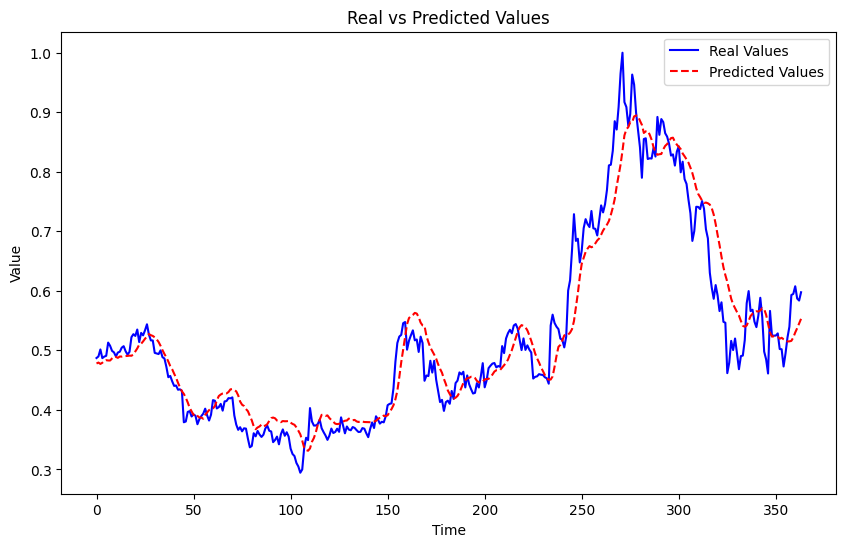

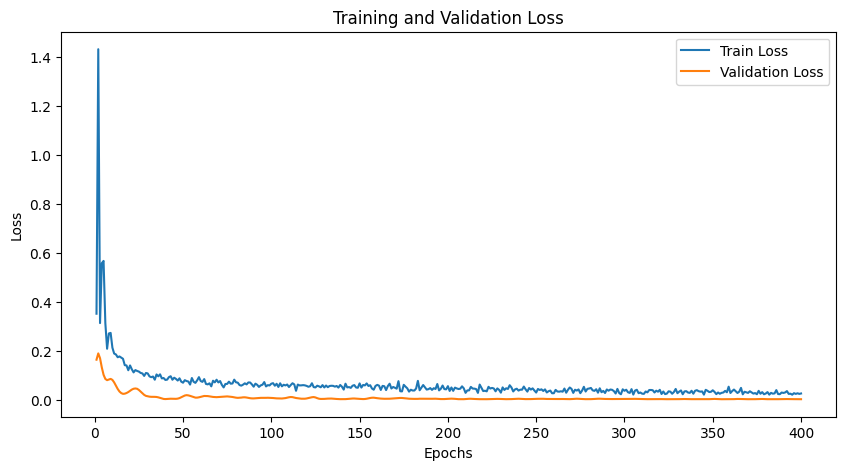

In [61]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.1
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_tesla_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_10_fractal.png', train_losses, val_losses, num_epochs)

## STEP = 20

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.2042, Train MAE: 0.1199
Val RMSE: 0.0845, Val MAE: 0.0734
Epoch 200/400:
Train RMSE: 0.1716, Train MAE: 0.0882
Val RMSE: 0.0754, Val MAE: 0.0667
Epoch 300/400:
Train RMSE: 0.1462, Train MAE: 0.0707
Val RMSE: 0.0523, Val MAE: 0.0378
Epoch 400/400:
Train RMSE: 0.1228, Train MAE: 0.0595
Val RMSE: 0.0618, Val MAE: 0.0474

Final Results:
Test RMSE: 0.1042
Test MAE: 0.0683


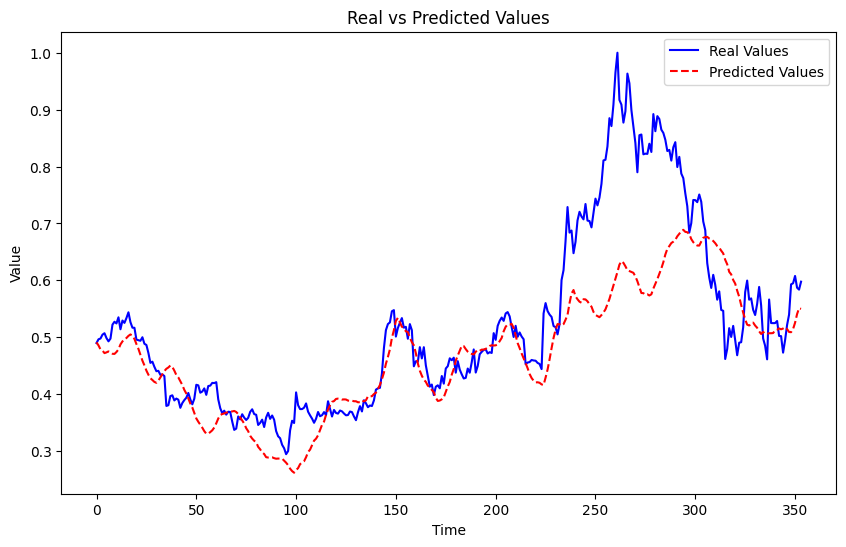

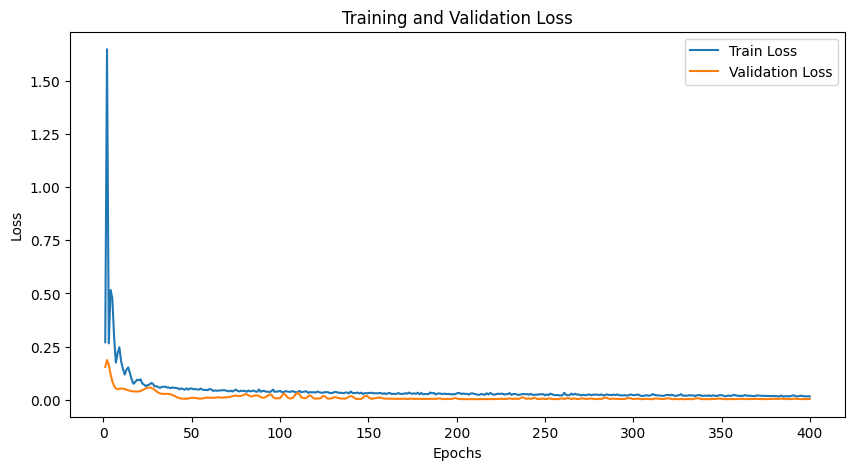

In [62]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.1
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_df, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_tesla_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_20_fractal.png', train_losses, val_losses, num_epochs)

## without indicators

In [63]:
cols = ['Open', 'Low', 'High', 'Volume', 'Close']
cols1 = ['Open', 'Low', 'High', 'Volume']

data_without_indicators = tesla_df[cols]

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.3616, Train MAE: 0.1919
Val RMSE: 0.1146, Val MAE: 0.0923
Epoch 200/400:
Train RMSE: 0.2999, Train MAE: 0.1419
Val RMSE: 0.0422, Val MAE: 0.0360
Epoch 300/400:
Train RMSE: 0.2433, Train MAE: 0.1057
Val RMSE: 0.0349, Val MAE: 0.0283
Epoch 400/400:
Train RMSE: 0.1955, Train MAE: 0.0845
Val RMSE: 0.0293, Val MAE: 0.0235

Final Results:
Test RMSE: 0.0376
Test MAE: 0.0268


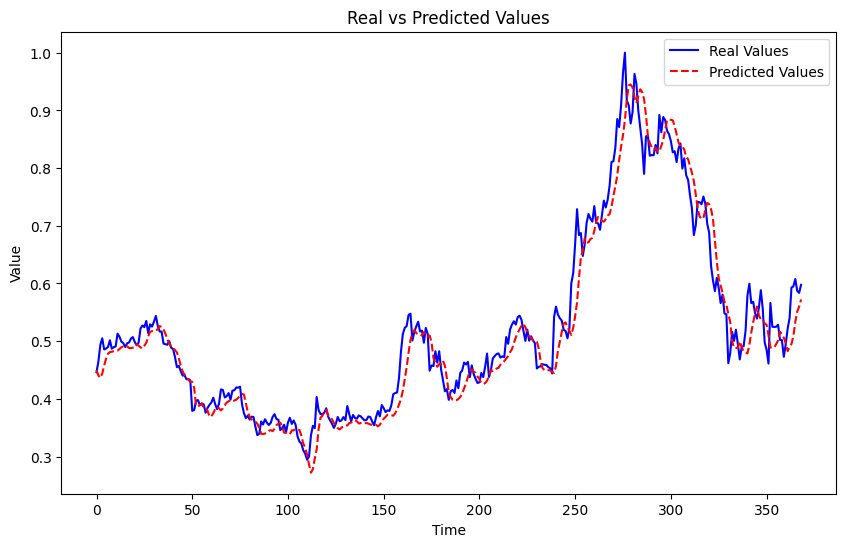

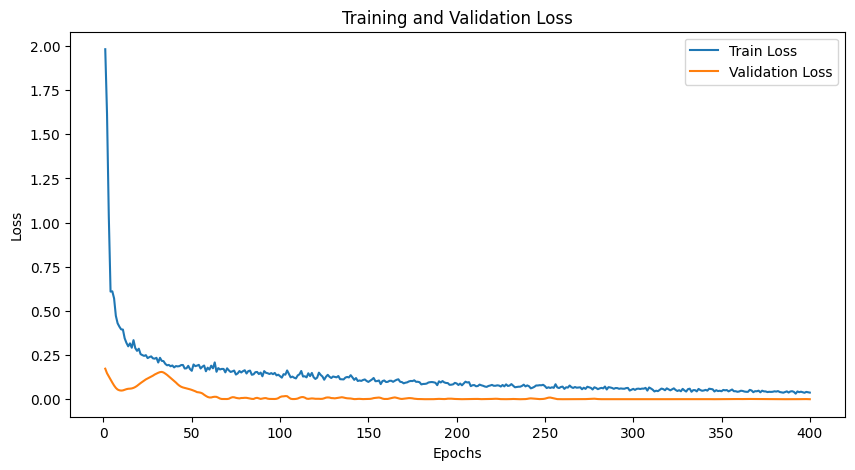

In [65]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 4
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.1
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data_without_indicators, cols1, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_tesla_without_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device,  'tesla_step_5_without_fractal.png', train_losses, val_losses, num_epochs)

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.2571, Train MAE: 0.1359
Val RMSE: 0.0385, Val MAE: 0.0283
Epoch 200/400:
Train RMSE: 0.2279, Train MAE: 0.1120
Val RMSE: 0.0353, Val MAE: 0.0271
Epoch 300/400:
Train RMSE: 0.2106, Train MAE: 0.0992
Val RMSE: 0.0756, Val MAE: 0.0664
Epoch 400/400:
Train RMSE: 0.1975, Train MAE: 0.0878
Val RMSE: 0.0326, Val MAE: 0.0256

Final Results:
Test RMSE: 0.0407
Test MAE: 0.0299


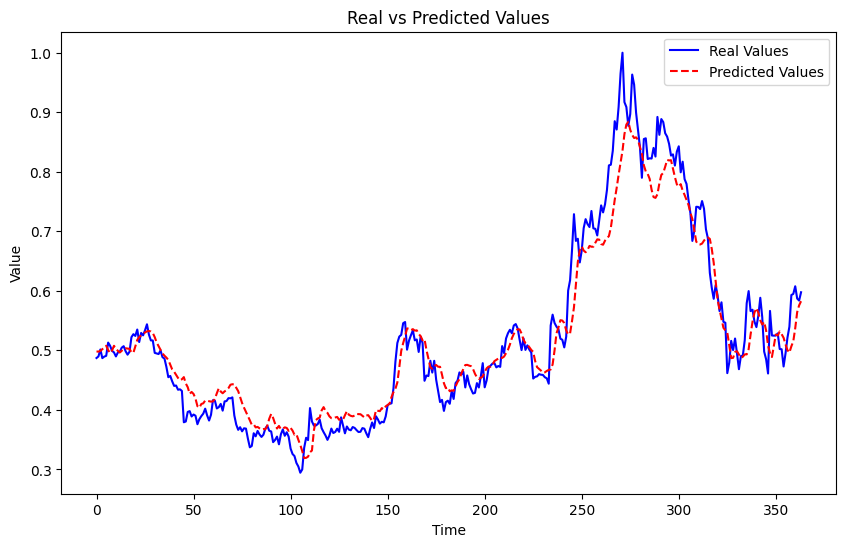

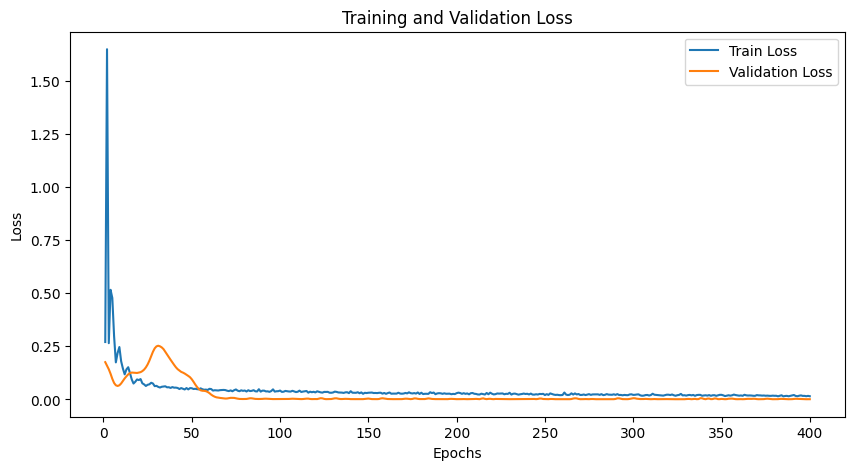

In [64]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 4
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.1
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data_without_indicators, cols1, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_tesla_without_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_10_without_fractal.png', train_losses, val_losses, num_epochs)

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 100/400:
Train RMSE: 0.2247, Train MAE: 0.1188
Val RMSE: 0.0670, Val MAE: 0.0525
Epoch 200/400:
Train RMSE: 0.1901, Train MAE: 0.0991
Val RMSE: 0.0549, Val MAE: 0.0444
Epoch 300/400:
Train RMSE: 0.1718, Train MAE: 0.0848
Val RMSE: 0.0458, Val MAE: 0.0364
Epoch 400/400:
Train RMSE: 0.1673, Train MAE: 0.0781
Val RMSE: 0.0382, Val MAE: 0.0303

Final Results:
Test RMSE: 0.0515
Test MAE: 0.0380


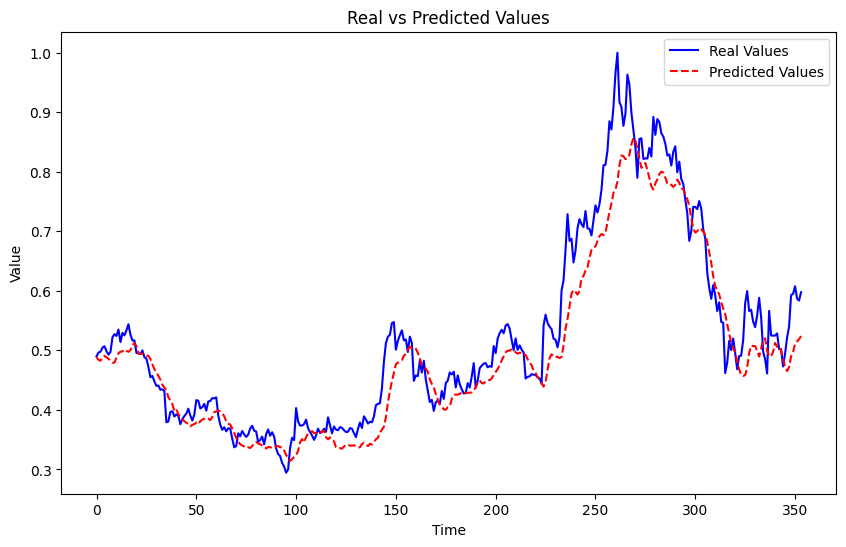

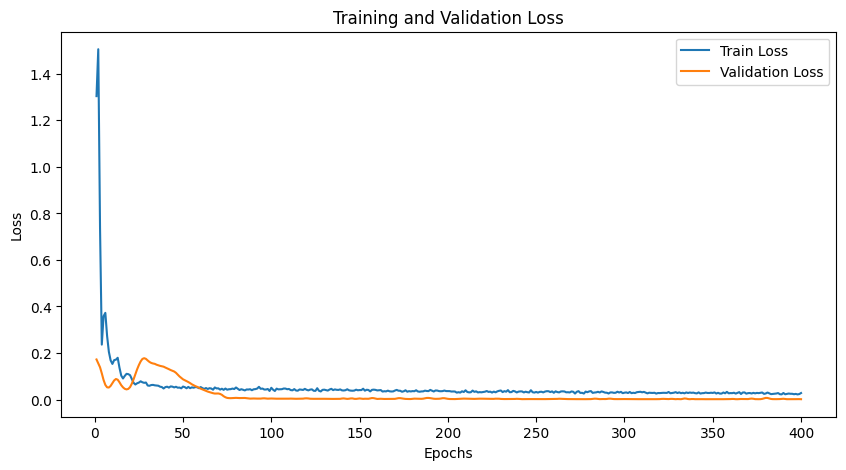

In [66]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 3
in_channels = 4
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.1
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(data_without_indicators, cols1, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_tesla_without_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_20_without_fractal.png', train_losses, val_losses, num_epochs)